<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/using_fiftyone_in_icevision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Disclaimer

This notebook won't work in Colab, due to an incompatibility with the `fiftyone` library.

# Using Fiftyone in IceVision

![](https://raw.githubusercontent.com/airctic/icevision/master/images/fridge-objects.png)

## Install IceVision
The following downloads and runs a short shell script. The script installs IceVision, IceData, the MMDetection library, and Yolo v5 as well
as the fastai and pytorch lightning engines.

Install from pypi...

In [ ]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11

... or from icevision master

In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11 master

`fiftyone` is not part of IceVision. We need to install it separately.

In [ ]:
# Install fiftyone
%pip install fiftyone -U

In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

## Imports
All of the IceVision components can be easily imported with a single line.


In [ ]:
from icevision.all import *
from icevision.models import * # Needed for inference later
import icedata  # Needed for sample data
import fiftyone as fo

## Visualizing datasets

The fiftyone integration of IceVision can be used on either IceVision Datasets or IceVision Prediction. Let's start by visualizing a dataset. 

If you don't know fiftyone yet, visit the website and read about the concepts: https://voxel51.com/docs/fiftyone. 

### Fiftyone Summary

Fiftyone is a tool to analyze datasets and detections of all forms. 

For object detection these concepts are most relevant: 

Fiftyone is structured into `fo.Datasets`. So every viewable entity is related to a `fo.Dataset`. An image is represented by a `fo.Sample`. After you created a `fo.Sample` you can add `fo.Detections`, which is constructed by a list of `fo.Detection`. Finally, you need to add a `fo.Sample` to your `fo.Dataset` and then launch your app by calling `fo.launch_app(dataset)`. IceVision enables you to create all of these `fo` objects from IceVision classes.

Before we train or execute inference, we need to create an `icevision.Dataset`. From this dataset, we can create a `fo.Dataset`.
Since fiftyone operates on filepaths, you dataset needs filepath as component and you cannot use `Dataset.from_images` as it stores the images in RAM.

We use the fridge object dataset available from [IceData](https://airctic.github.io/icedata/install/).

In [2]:
# List all available fiftyone datasets on your machine:
fo.list_datasets()

[]

In [ ]:
# Download dataset
infer_ds_path = icedata.fridge.load_data()
train_records, valid_records = icedata.fridge.parser(infer_ds_path).parse()

# Set fo dataset name
fo_dataset_name = "inference_dataset"

#RandomSplitter Create fiftyone dataset
fo_dataset = data.create_fo_dataset(valid_records, fo_dataset_name)

In [4]:
# See your new dataset in the lists
fo.list_datasets()

['inference_dataset']


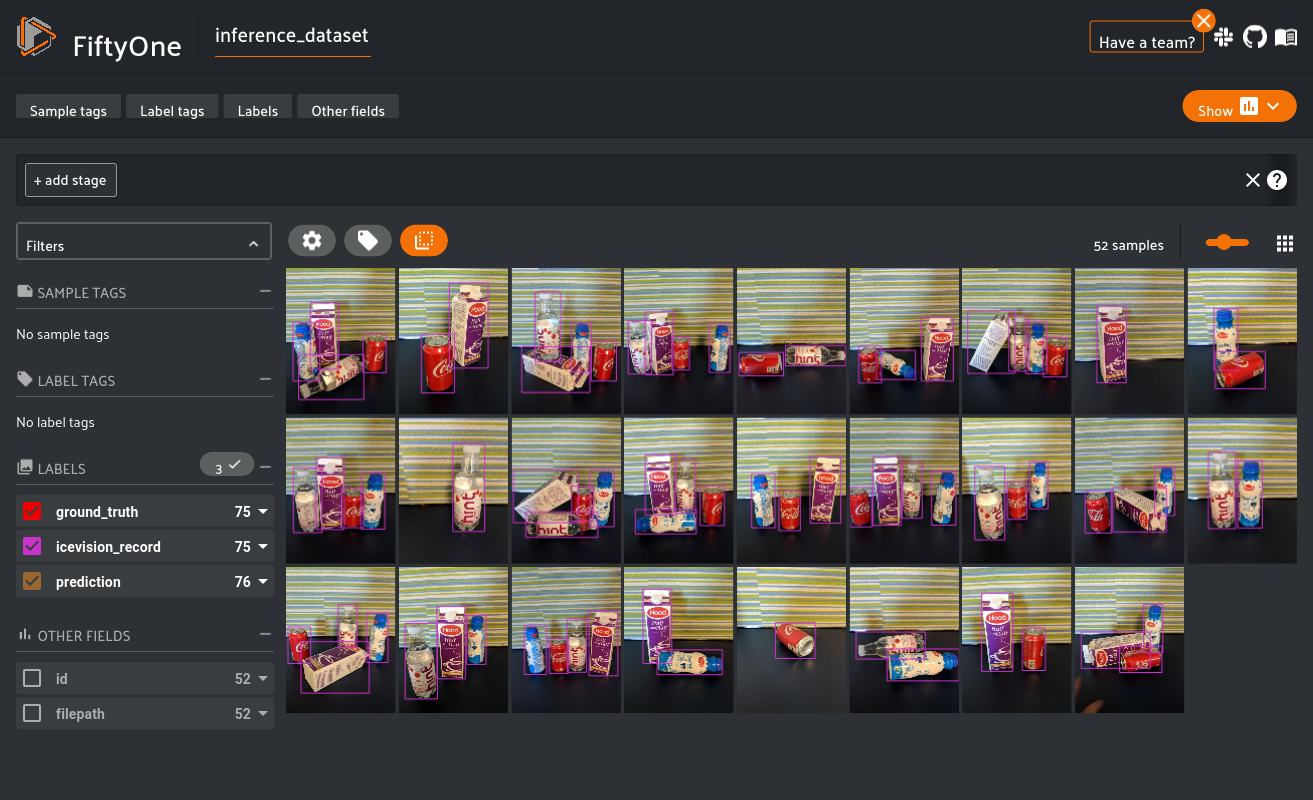

Dataset:          inference_dataset
Media type:       image
Num samples:      26
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

In [5]:
fo.launch_app(fo_dataset)

## Visualizing predictions

Besides Datasets, you can also visualize predictions by calling the `icevision.data.create_fo_dataset` with an `icevision.Prediction`. The `icevision.data.create_fo_dataset` function allows you to append prediction to an existing dataset by setting the `exist_ok` argument to `True`.

When you display images in fiftyone it always refers to the original image. However, Icevision keeps its data already transformed, which means that the bounding box needs to be post-processed to match the original image size. You have two options for this post-processing:

1. Either use IceVisions internal function by using the `transformation` argument in the `icevision.data.create_fo_dataset` function
2. Or u
se your custom post-process function by using the `undo_bbox_tfms_fn` argument

### Loading the fridge model

In [ ]:
checkpoint_path = 'https://github.com/airctic/model_zoo/releases/download/m6/fridge-retinanet-checkpoint-full.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)

In [ ]:
# Just logging the info
model_type = checkpoint_and_model["model_type"]
backbone = checkpoint_and_model["backbone"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]
model_type, backbone, class_map, img_size

In [ ]:
# Inference

# Model
model = checkpoint_and_model["model"]

# Transforms
img_size = checkpoint_and_model["img_size"]
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

# Create dataset
infer_ds = Dataset(valid_records, valid_tfms)

# Batch Inference
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

In [9]:
# Lets add the predictions to our previous dataset. 

fo_dataset = data.create_fo_dataset(detections=preds,
                                   dataset_name=fo_dataset_name,
                                   exist_ok=True,
                                   transformations=valid_tfms.tfms_list)  # Use IceVisions automatic postprocess bbox function by adding the tfms_list

In [10]:
# List datasets, to see that no new is created
fo.list_datasets()

['inference_dataset']


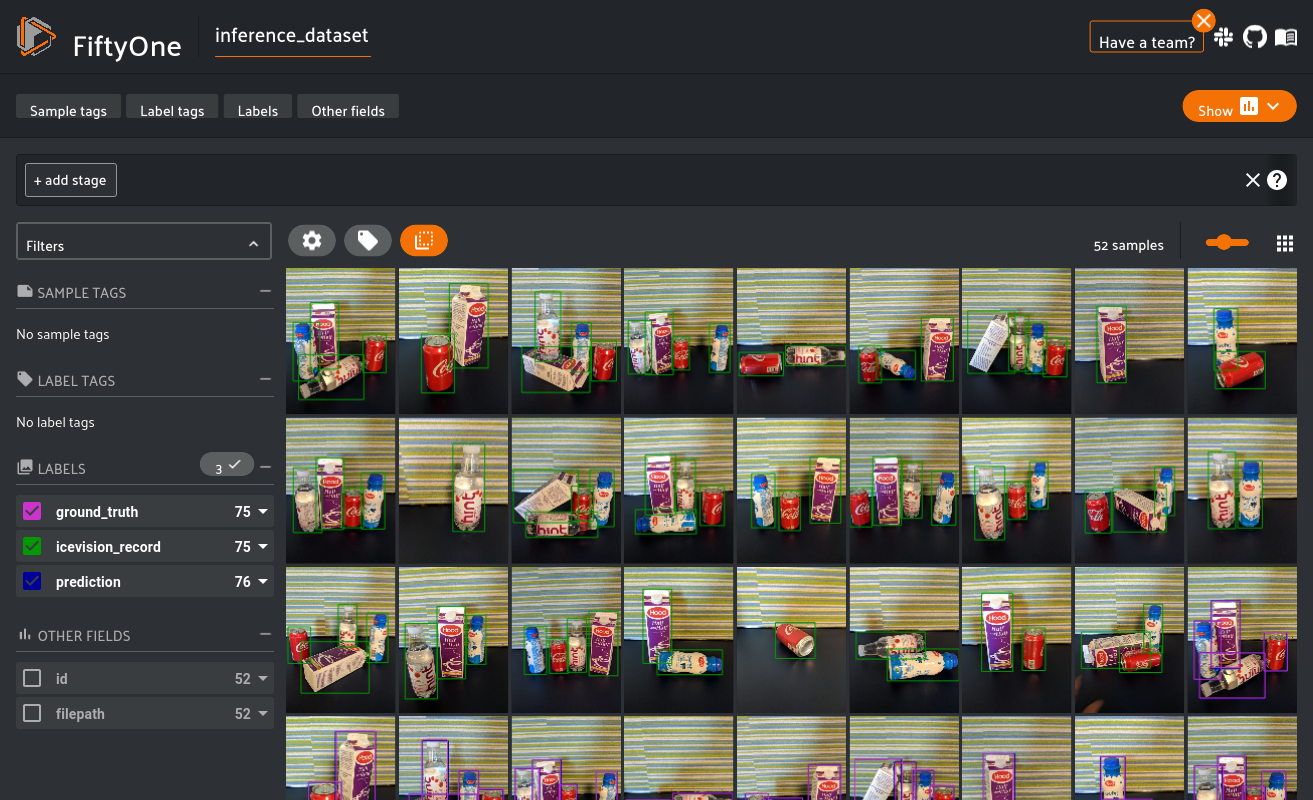

Dataset:          inference_dataset
Media type:       image
Num samples:      52
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

In [11]:
fo.launch_app(fo_dataset)

### Merging samples
You can see that images are not automatically matched by filepaths. Therefore use [`fo.Dataset.merge_samples`](https://voxel51.com/docs/fiftyone/recipes/merge_datasets.html).

## Create your own fo.Dataset with fo.Sample

This is handy if you need more control over individual samples. For example, you want to compare several training runs, you can create your own `fo.Sample` and add records manually to avoid merging samples afterward.
We provide 2 functions to create `fo.Samples`:

1. `data.convert_prediction_to_fo_sample`
2. `data.convert_record_to_fo_sample`

In [12]:
# Create custom dataset
custom_fo_dataset_name = "custom_fo_dataset"
custom_dataset = fo.Dataset(custom_fo_dataset_name)

# Load dataset
infer_ds_path = icedata.fridge.load_data()
train_records, valid_records = icedata.fridge.parser(infer_ds_path).parse()

sample_list = []

# Iter over dataset and create samples based on records
# The field_name refers to the fields of fiftyone, which is used to structure samples in fiftyone
for record in train_records[:1]:
    sample = fo.Sample(record.common.filepath)  # Create sample and use it in the function below
    sample_list.append(data.convert_record_to_fo_sample(record=record,
                                                        field_name="train_set",
                                                        sample=sample)
                      )

# Prediction have their own convert function
for pred in preds[:1]:
    sample_list.append(data.convert_prediction_to_fo_sample(prediction=pred, transformations=valid_tfms.tfms_list))

# Print our samples
print(sample_list)

# Add our samples to the dataset
custom_dataset.add_samples(samples=sample_list)

  0%|          | 0/128 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/128 [00:00<?, ?it/s]

[<Sample: {
    'id': None,
    'media_type': 'image',
    'filepath': '/home/laurenz/.icevision/data/fridge/odFridgeObjects/images/94.jpg',
    'tags': [],
    'metadata': None,
    'train_set': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '61efa9f66ae4a8a68dd47c92',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'carton',
                'bounding_box': BaseList([
                    0.036072144288577156,
                    0.3033033033033033,
                    0.3226452905811623,
                    0.506006006006006,
                ]),
                'mask': None,
                'confidence': None,
                'index': None,
            }>,
            <Detection: {
                'id': '61efa9f66ae4a8a68dd47c93',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'water_bottle',
                'bounding_b

['61efa9f66ae4a8a68dd47c9e', '61efa9f66ae4a8a68dd47ca3']

In [13]:
fo.launch_app(custom_dataset)

Dataset:          custom_fo_dataset
Media type:       image
Num samples:      2
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

### Cleanup

In [ ]:
fo.delete_dataset(fo_dataset_name)
fo.delete_dataset(custom_fo_dataset_name)

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).